In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import scipy
import scipy.stats as ss
%matplotlib inline
matplotlib.rcParams['font.size'] = 18
matplotlib.rcParams['figure.dpi'] = 75
import seaborn as sns
from statsmodels.sandbox.stats.multicomp import multipletests

## Part a

In [ ]:
#We removed manually the first rows which started with "!". It was just some metadata...
df = pd.read_csv("AMI_GSE66360_series_matrix.csv")
#We decided to change the dimension of dataframe s.t. Patients are rows, and columns are the ID,Class and genes. 
df = df.T

In [3]:
df.reset_index(inplace=True)
df.columns = df.iloc[0]
df.drop(df.index[0],inplace=True)

In [4]:
df.shape #Again, the dimension is changed. 

(99, 54677)

In [5]:
df["Class"].value_counts()

H    50
M    49
Name: Class, dtype: int64

In [6]:
df.dropna(axis='columns',inplace=True) #Removing columns instead of rows because columns are genes.
df.shape

(99, 54630)

## Part b

Text(0.5, 0, 'RS(g)')

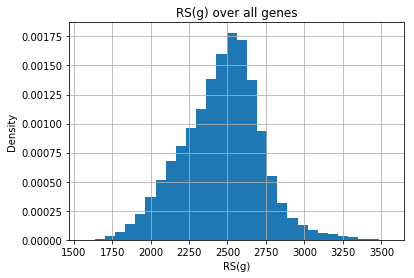

In [24]:
classes = df.iloc[:,1]
M_vector = classes == "M"
H_vector = classes == "H"

def calculate_RS(g):
    ranks = g.rank()
    return ranks[M_vector].sum()

ranked_df = df.iloc[:,2:].apply(calculate_RS, axis=0)
ranked_df.hist(bins=30,density=True)
plt.title("RS(g) over all genes")
plt.ylabel("Density")
plt.xlabel("RS(g)")

## Part c

In [79]:
alpha = 0.05*2 #Since ss.ranksums is a two-sided test, we need to multiply alpha by 2 

def WRS_test(g):
    return ss.ranksums(g[M_vector],g[H_vector])

WRS_df = df.iloc[:,2:].apply(WRS_test, axis=0,result_type="expand")

In [80]:
WRS_test_overexpressed_df = WRS_df.T[(WRS_df.T.iloc[:,0] > 0) & (WRS_df.T.iloc[:,1] < alpha)]
WRS_test_underexpressed_df = WRS_df.T[(WRS_df.T.iloc[:,0] <= 0) & (WRS_df.T.iloc[:,1] < alpha)]
print("WRS Overexpressed Genes compared to H :",WRS_test_overexpressed_df.shape[0])
print("WRS Underexpressed Genes compared to H :",WRS_test_underexpressed_df.shape[0])

WRS Overexpressed Genes compared to H : 8991
WRS Underexpressed Genes compared to H : 9424


In [81]:
def t_test(g):
    return ss.ttest_ind(g[M_vector].astype("float"), g[H_vector].astype("float"), equal_var = False)

t_test_df = df.iloc[:,2:].apply(t_test, axis=0,result_type="expand")

In [82]:
t_test_overexpressed_df = t_test_df.T[(t_test_df.T.iloc[:,0] > 0) & (t_test_df.T.iloc[:,1] < alpha)]
t_test_underexpressed_df = t_test_df.T[(t_test_df.T.iloc[:,0] <= 0) & (t_test_df.T.iloc[:,1] < alpha)]
print("t Test Overexpressed Genes compared to H :",t_test_overexpressed_df.shape[0])
print("t Test Underexpressed Genes compared to H :",t_test_underexpressed_df.shape[0])

t Test Overexpressed Genes compared to H : 7035
t Test Underexpressed Genes compared to H : 7454


## Part d

In [12]:
under_significant_df = WRS_test_underexpressed_df.sort_values(by=WRS_test_underexpressed_df.columns[1]).head(60)
over_significant_df = WRS_test_overexpressed_df.sort_values(by=WRS_test_overexpressed_df.columns[1]).head(60)
D = over_significant_df.append(under_significant_df)
D_df = df[D.index].astype("float")
D_df_corr = D_df.corr(method="spearman")

In [13]:
def calculate_pvalues(df):
    dfcols = pd.DataFrame(columns=df.columns)
    pvalues = dfcols.transpose().join(dfcols, how='outer')
    for r in df.columns:
        for c in df.columns:
            pvalues[r][c] = ss.spearmanr(df[r], df[c])[1]
    return pvalues

D_df_corr_pvalues = calculate_pvalues(D_df)

In [64]:
alpha = 0.05
significant_pvalues = D_df_corr_pvalues[D_df_corr_pvalues < alpha].count()
total_pairs = scipy.special.comb(D.shape[0],D.shape[1])
significant_pairs = (np.sum(significant_pvalues) - 120)/2
print("Total pairs : {}".format(int(total_pairs)))
print("Significant co-expressed gene pairs : {}".format(int(significant_pairs)))
print("{}% of pairs are Significant".format(round(significant_pairs/total_pairs,2)*100))

Total pairs : 7140
Significant co-expressed gene pairs : 6955
97.0% of pairs are Significant


### Only "M" labeled

In [71]:
D_M_df = D_df[M_vector]
D_M_df_corr = D_M_df.corr(method="spearman")
D_M_df_corr_pvalues = calculate_pvalues(D_M_df)

In [72]:
significant_pvalues = D_M_df_corr_pvalues[D_M_df_corr_pvalues < alpha].count()
significant_pairs = (np.sum(significant_pvalues) - 120)/2
print("Total pairs : {}".format(int(total_pairs)))
print("Significant co-expressed gene pairs : {}".format(int(significant_pairs)))
print("{}% of pairs are Significant".format(round(significant_pairs/total_pairs,2)*100))

Total pairs : 7140
Significant co-expressed gene pairs : 3262
46.0% of pairs are Significant


## Part e

In [15]:
def overabundance(statistic_df, test_type):
    number_of_genes = df.shape[1]
    overabundance_df = statistic_df.copy()
    overabundance_df["statistic"] = overabundance_df["statistic"].abs()
    overabundance_df["expected distribution"] = overabundance_df["p_value"]*number_of_genes
    overabundance_df["actual distribution"] = overabundance_df["statistic"].rank(ascending = False)   
    ax = overabundance_df[["expected distribution", "actual distribution", "p_value"]]
    ax = ax.sort_values(by="p_value").plot(x="p_value")
    ax.set_xscale("log")
    ax.set_title(test_type)
    plt.ylabel("Number of genes")
    plt.show()

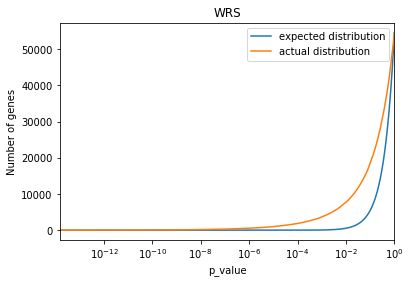

In [16]:
WRS_df.index=["statistic", "p_value"]
overabundance(WRS_df.T, "WRS")

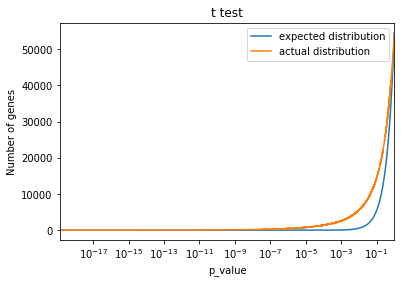

In [17]:
t_test_df.index=["statistic", "p_value"]
overabundance(t_test_df.T, "t test")

In [18]:
def calc_fdr(pvals,test_type):
    for FDR in [0.1, 0.05, 0.001]:
        reject, pvals_corrected, _, _ = multipletests(pvals, alpha=FDR, method='fdr_bh')
        number_of_genes_under_threshold = np.count_nonzero(reject)
        print("Test Type : {}, FDR: {}, Number of genes: {}".format(test_type, FDR, number_of_genes_under_threshold))

In [19]:
calc_fdr(WRS_df.loc["p_value"],"WRS")
calc_fdr(t_test_df.loc["p_value"],"t test")

Test Type : WRS, FDR: 0.1, Number of genes: 9335
Test Type : WRS, FDR: 0.05, Number of genes: 6539
Test Type : WRS, FDR: 0.001, Number of genes: 1267
Test Type : t test, FDR: 0.1, Number of genes: 5652
Test Type : t test, FDR: 0.05, Number of genes: 3905
Test Type : t test, FDR: 0.001, Number of genes: 915


In [20]:
D_three = D.sample(n=3)
D_three = df[D_three.index]
D_three.head()

,239642_at,203888_at,201842_s_at
1,10.3694,5.7805,3.50202
2,9.28862,6.13424,3.45337
3,9.36868,3.37199,3.28991
4,9.69926,5.64824,5.0591
5,9.67628,5.73438,2.92799


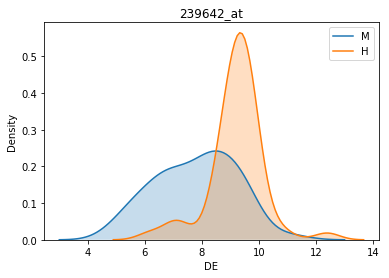

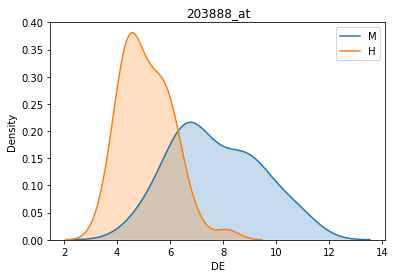

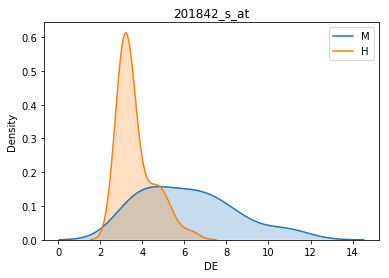

0
239642_at      None
203888_at      None
201842_s_at    None
dtype: object

In [21]:
def plot_exp_pattern(g):
    sns.kdeplot(g[M_vector], shade=True, label="M")
    sns.kdeplot(g[H_vector], shade=True, label="H")
    plt.title(g.name)
    plt.xlabel("DE")
    plt.ylabel("Density")
    plt.show()
    
D_three.apply(plot_exp_pattern, axis=0)

In [22]:
exp_values = list(range(2,15))
exp_df = pd.DataFrame(np.zeros((len(D_df.T.index), len(exp_values))),columns=exp_values,index=D_df.T.index)
for index, row in D_df.T.iterrows():
    for value in row:
        exp_df.loc[index,int(value)] += 1
exp_df.index.name = "Gene"
        

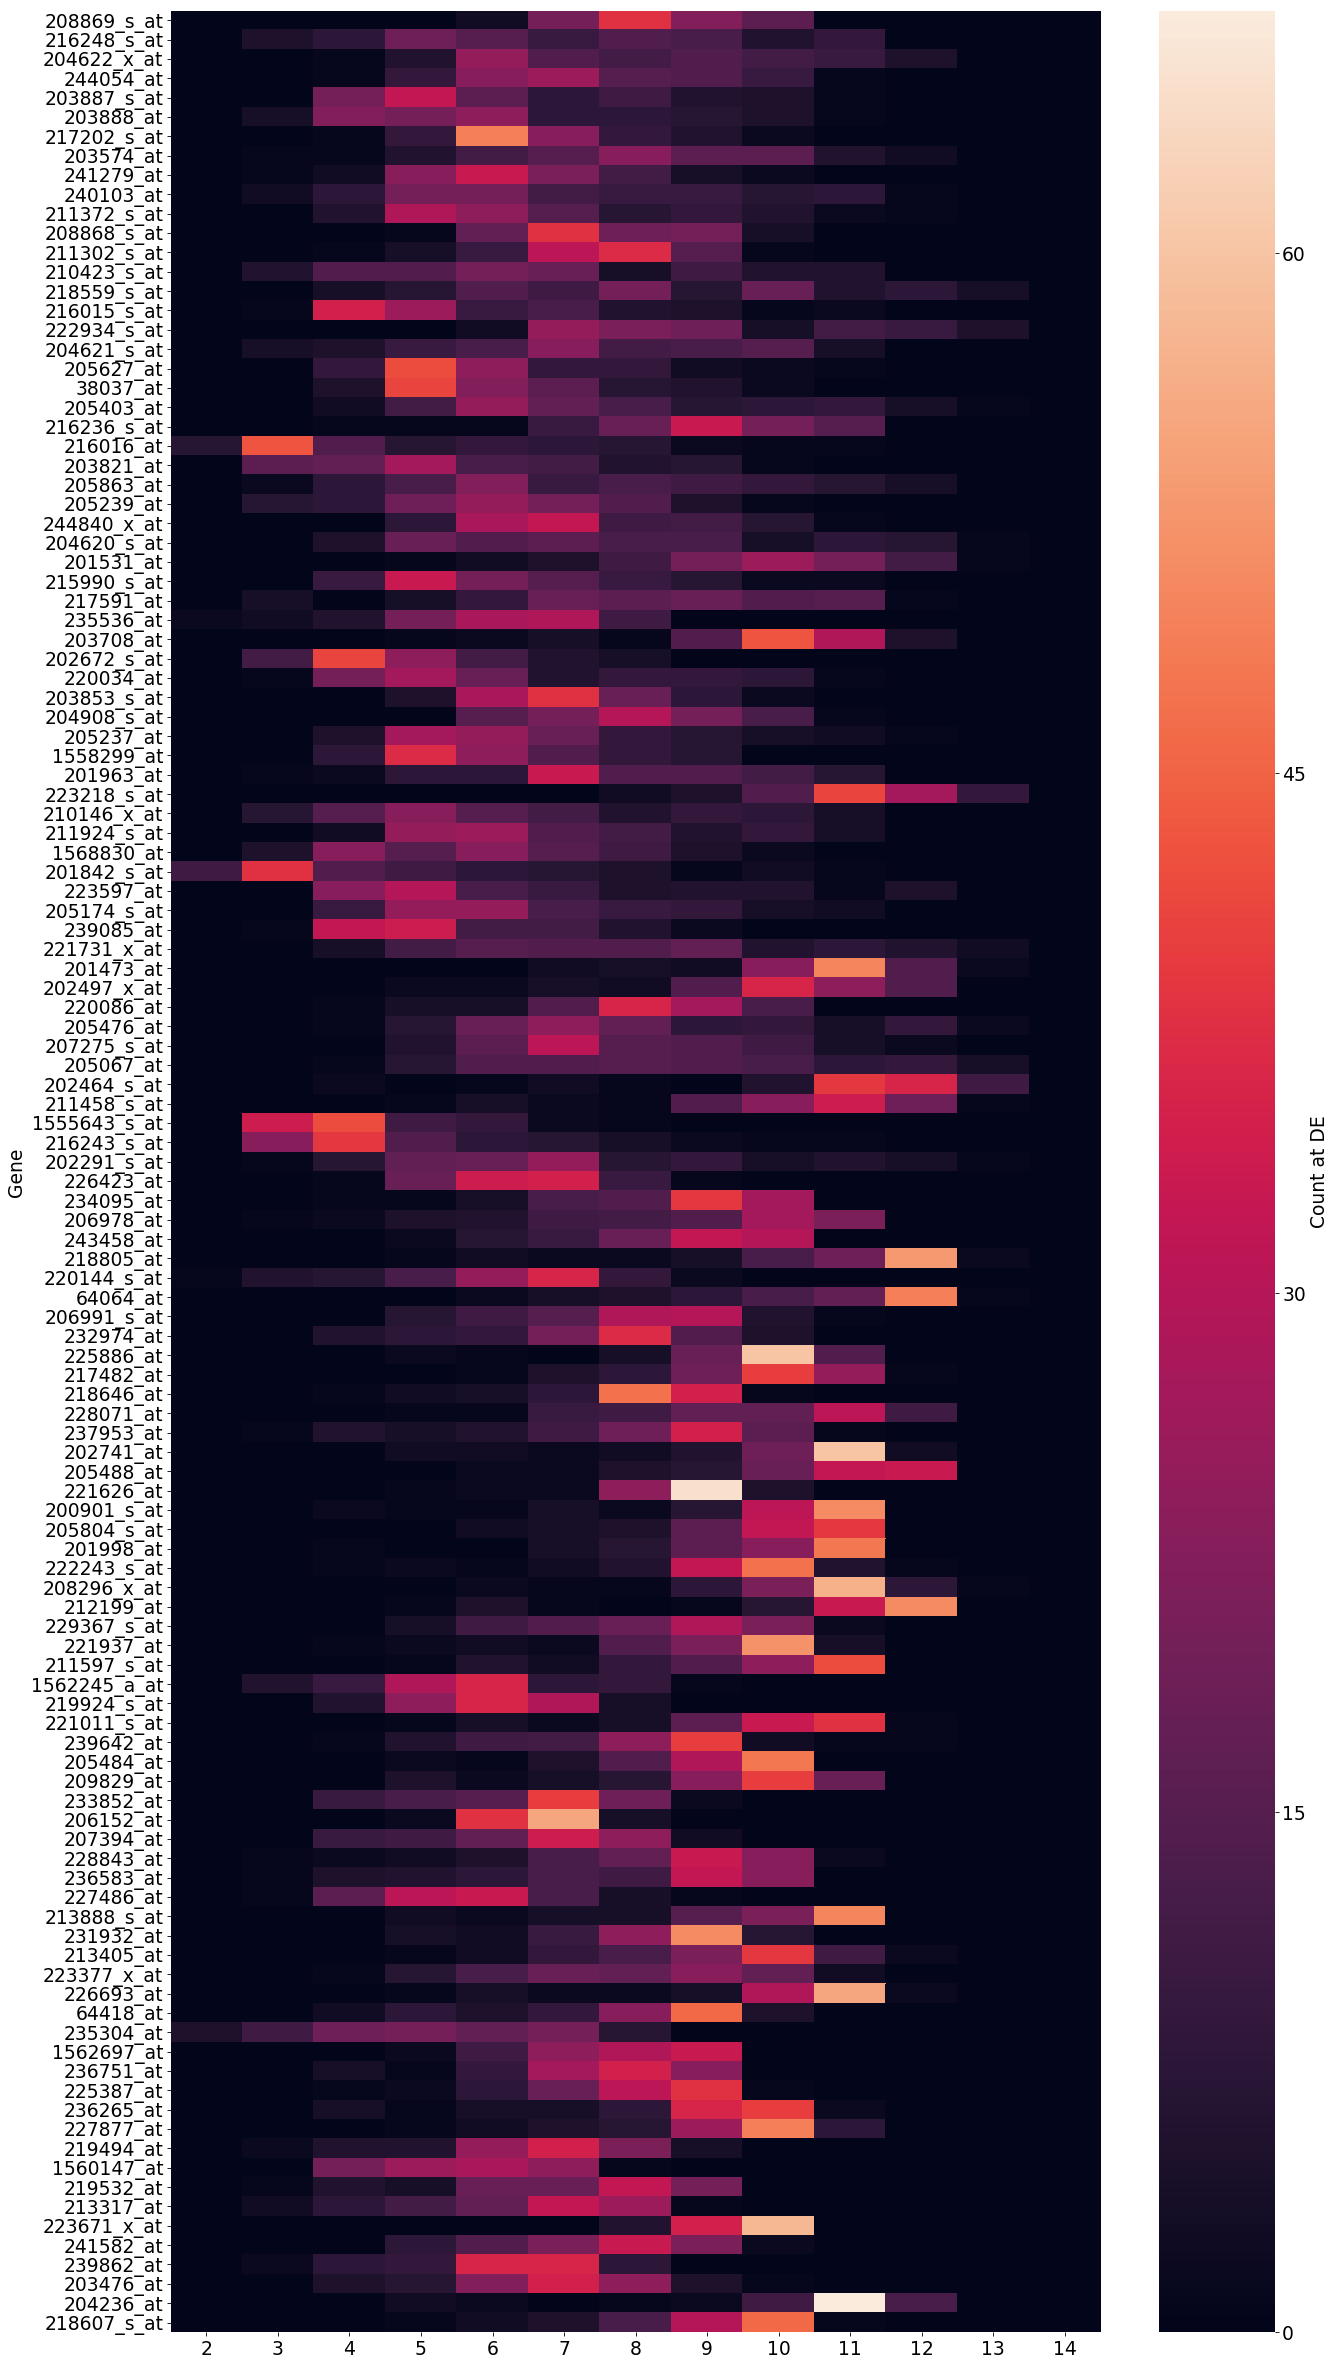

In [76]:
plt.figure(figsize = (20,41))
sns.heatmap(exp_df,cbar_kws={'label': 'Count at DE'})